## DL model to predict secondary structure of proteins from sequence

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.layers import GaussianNoise

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.constraints import maxnorm
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

from sklearn.pipeline import Pipeline


Using TensorFlow backend.
/Users/abhinav/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/abhinav/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/abhinav/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/abhinav/opt/anaconda3/lib/pytho

## One-hot encoder for amino acids

In [2]:
def onehotencoder_for_aminoacids(x):
    """ generate a OneHotEncoder for amino acids """
    
    aminoacids = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    categories = [aminoacids for i in range(x.shape[1])]
    encoder = OneHotEncoder(categories=categories, handle_unknown='ignore') # for all amino acids
#     encoder = OneHotEncoder(handle_unknown='ignore') # only for amino acids present in data

    encoder.fit(x)
    return encoder
    

## Encode a protein sequence

In [3]:
def encode_sequence(seq, encoder):
    """ take a single sequence and encode it
    seq: e.g. 'AVGHY'
    encoder: already ceated by onehotencoder_for_aminoacids 
    return encoded_seq
    """

    nparray = np.array(list(seq))
    encoded_seq = encoder.transform([nparray])
    return encoded_seq
    

In [4]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'])

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('model accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'])

    plt.tight_layout()

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test):

    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    print (f"Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print (f"Test  Loss: {test_loss:.3f}, Test  Accuracy: {test_accuracy:.3f}")
    return train_accuracy, test_accuracy


## Read in data

#### The secondary structure data was obtained from PDB https://www.rcsb.org/pages/download/http#ss
#### This was processed by parse_ss script to split our three secondary structures (helix, strand and coil). In this example the calculataion is limited to protein sequences of length 8

In [6]:
df = pd.read_csv("ss_data_length_8.csv")
# df = pd.read_csv("ss_data_length_8_augmented.csv")

# df2 = pd.read_csv("ss_data_length_8_augmented.csv")
# df = pd.concat([df1,df2]).drop_duplicates()
df = df.drop_duplicates()
print (f"Number of samples: {df.shape[0]}")
print (f"Top 5 rows of the data:\n {df.head(5)}")
print (df.groupby('ss').count())

Number of samples: 111805
Top 5 rows of the data:
    sequence ss  length
0  TNSLRMLQ  H       8
1  IFEMLRID  H       8
2  WDEAAVNL  H       8
3  PKLKAFLA  H       8
4  ERIYMICF  E       8
    sequence  length
ss                  
C      23102   23102
E      43425   43425
H      45278   45278


## Generate X and Y

In [7]:
# Create data for Classification
split_seq = df['sequence'].str.split('',expand=True)
X = pd.DataFrame(split_seq)
X = X[X!=''].dropna(axis=1).values
Y = df['ss'].values

## Encode label (Y)

In [8]:
# encode the ss type
# first convert labels to integers: this is a long way
# le = LabelEncoder()
# le.fit(Y)
# encoded_Y = le.transform(Y)
# # Now convert integers to one-hot vectors
# encoded_Y = np_utils.to_categorical(encoded_Y)
# encoded_Y[0]

In [9]:
# encode the ss type
# A shorter way
Y = Y.reshape(-1,1)
y_encoder = OneHotEncoder(handle_unknown='ignore') 
y_encoder.fit(Y)
encoded_Y = y_encoder.transform(Y)
# y_encoder.get_feature_names()
# np.array(encoded_Y.toarray())

## Encode sequences (X)

In [10]:
# encode the sequence to one hot values
encoder = onehotencoder_for_aminoacids(X)
encoded_X = encoder.transform(X)
# check if the encoder works fine
print (f"First sequence: {X[0]}")
print(f"First encoded sequence inverse transformed to verify: {encoder.inverse_transform(encoded_X[0])}")
print(f"Shapes of input and encoded sequences: {X.shape}, {encoded_X.shape}")
input_dim = encoded_X.shape[1]
print(f"Number of features: {input_dim}")

First sequence: ['T' 'N' 'S' 'L' 'R' 'M' 'L' 'Q']
First encoded sequence inverse transformed to verify: [['T' 'N' 'S' 'L' 'R' 'M' 'L' 'Q']]
Shapes of input and encoded sequences: (111805, 8), (111805, 160)
Number of features: 160


## Test/train split

In [11]:
# split into train test
X_train, X_test, y_train, y_test = train_test_split(encoded_X, encoded_Y, 
                                                    test_size=0.3, 
                                                    random_state=0,
                                                    stratify=encoded_Y.toarray())

## Create a model

In [12]:
# create model
def baseline_model(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))  
    model.add(Dense(3, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

## Cross_val_score with a baseline model

In [13]:
results = []
epochs = 40

In [14]:
kfold = KFold(n_splits=5, shuffle=True)
# kfold = StratifiedKFold(n_splits=5, shuffle=True)

y_train_arr = np.array(y_train.toarray())

# This could be sampled better using GridSearchCV.
# GridSearchCV takes a while, so just checking batch size manually

# batch_sizes = [256, 512, 1024, 2048]
batch_sizes = [1024]

accuracies = []

for b in batch_sizes:
    start = datetime.now()
    estimator = KerasClassifier(build_fn=baseline_model, input_dim=input_dim, epochs=40, batch_size=b, verbose=0)
    cv_results = cross_val_score(estimator, X_train, y_train_arr, cv=kfold) 
    end = datetime.now()
    time_taken = str(end-start)
    print (f"Batch size: {b}, Mean accuracy: {cv_results.mean():.3f} ({cv_results.std():.3f}), Time taken: {time_taken}")
    accuracies.append(cv_results.mean())

# plt.plot(batch_sizes, accuracies)
# plt.plot(batch_sizes, accuracies, 'o')
# plt.title('Batch Size Effect')
# plt.ylabel('Accuracy')
# plt.xlabel('Batch size');



Batch size: 1024, Mean accuracy: 0.779 (0.001), Time taken: 0:01:37.967861


## Fit a baseline model

Train Loss: 0.374, Train Accuracy: 0.857
Test  Loss: 0.543, Test  Accuracy: 0.786


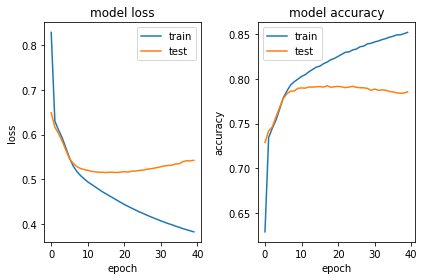

In [15]:
batch_size = 1024
model = baseline_model(input_dim)
# print (model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Basic',train_accuracy,test_accuracy))

## Test Accuracy = 78.3 %
### Need to try a few things to see if it improves
### Model seems over fitted. Add dropout. dropout rate of 0.3 seems to give reasonable results.

Train Loss: 0.419, Train Accuracy: 0.839
Test  Loss: 0.510, Test  Accuracy: 0.795


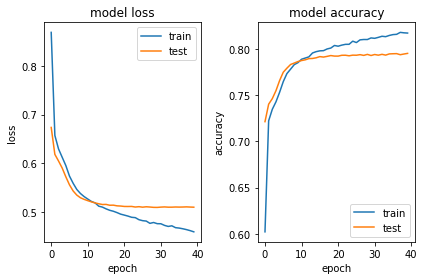

In [16]:
# create model
def model2(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu')) 
    model.add(Dropout(0.3)) 
    model.add(Dense(3, activation="softmax"))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model2(input_dim)
# print (model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Dropout',train_accuracy,test_accuracy))

## Test Accuracy = 79.3 %
### Test Learning rate schedule


Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Train Loss: 0.424, Train Accuracy: 0.835
Test  Loss: 0.510, Test  Accuracy: 0.794


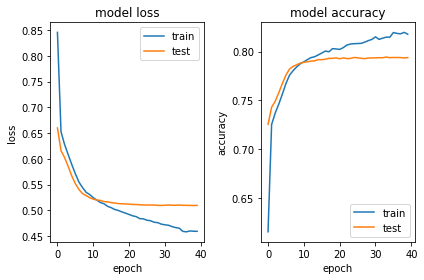

In [17]:
# create model
def model3(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu')) 
    model.add(Dropout(0.3))
    model.add(Dense(3, activation="softmax"))
    
    # Compile model
#     sgd = SGD(lr=lr, momentum=0.9, nesterov=False)
#     adam = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model3(input_dim)
# print (model.summary())
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1E-7, verbose=1)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, callbacks=[rlrp], verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Dropout+LRS',train_accuracy,test_accuracy))

### Learning rate schedule does not make any difference.

## Try batch normalization


Train Loss: 0.388, Train Accuracy: 0.850
Test  Loss: 0.526, Test  Accuracy: 0.789


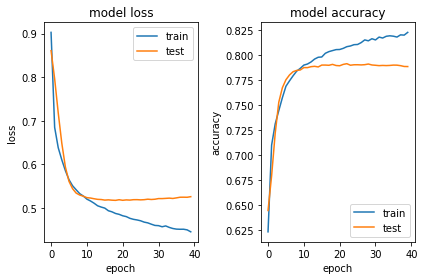

In [18]:
# create model
def model4(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu')) 
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(3, activation="softmax"))
    
    # Compile model
#     sgd = SGD(lr=lr, momentum=0.9, nesterov=False)
#     adam = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model4(input_dim)
# print (model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Dropout+BN',train_accuracy,test_accuracy))

### Batch Normalization improves Training accuracy at the expence of Test accuracy
## Try regularization

Train Loss: 0.584, Train Accuracy: 0.785
Test  Loss: 0.591, Test  Accuracy: 0.780


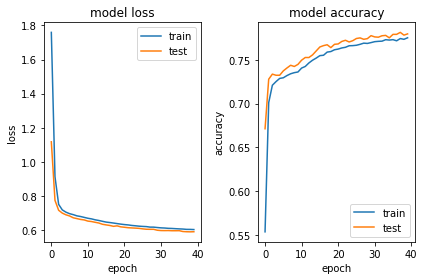

In [19]:
# create model
def model5(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(Dropout(0.3))
    model.add(Dense(3, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model5(input_dim)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Dropout+L2_regul',train_accuracy,test_accuracy))

## Try adding noise

Train Loss: 0.449, Train Accuracy: 0.825
Test  Loss: 0.509, Test  Accuracy: 0.794


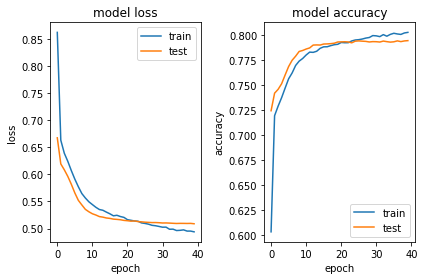

In [20]:
# create model
def model6(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu')) 
    model.add(Dropout(0.3))
    model.add(GaussianNoise(0.1))
    model.add(Dense(3, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model6(input_dim)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Dropout+Noise',train_accuracy,test_accuracy))

## Try noise + Deeper model

Train Loss: 0.441, Train Accuracy: 0.828
Test  Loss: 0.509, Test  Accuracy: 0.795


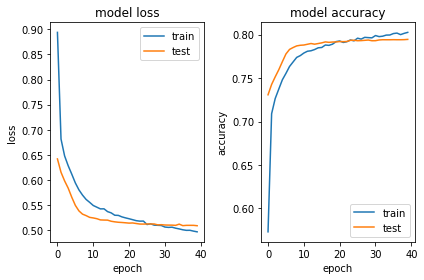

In [21]:
# create model
def model7(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu')) 
    model.add(Dropout(0.3))
    model.add(GaussianNoise(0.1))
    
    model.add(Dense(80, activation='relu')) 
    model.add(Dropout(0.3))
    model.add(GaussianNoise(0.1))
    
    model.add(Dense(3, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model7(input_dim)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Dropout+Noise+Layers',train_accuracy,test_accuracy))

## Try L2 regularization + Deeper model

Train Loss: 0.493, Train Accuracy: 0.833
Test  Loss: 0.581, Test  Accuracy: 0.789


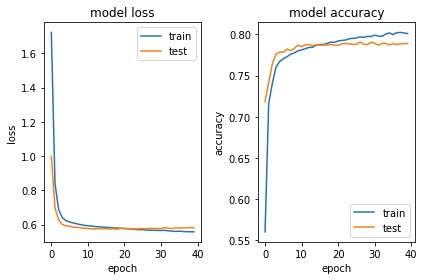

In [22]:
# create model
def model8(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(Dropout(0.3))
    
    model.add(Dense(80, activation='relu')) 
    model.add(Dropout(0.3))
    
    model.add(Dense(3, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model8(input_dim)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Dropout+L2_regul+Layers',train_accuracy,test_accuracy))

## Try Batch Normalization + Deeper model

Train Loss: 0.383, Train Accuracy: 0.854
Test  Loss: 0.520, Test  Accuracy: 0.792


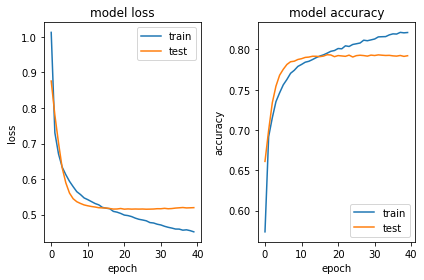

In [23]:
# create model
def model9(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu')) 
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(80, activation='relu')) 
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(3, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model9(input_dim)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Dropout+BN+Layers',train_accuracy,test_accuracy))

## Try Batch Normalization + Deeper model; replace Dropout by l2_regularization

Train Loss: 0.306, Train Accuracy: 0.928
Test  Loss: 0.930, Test  Accuracy: 0.744


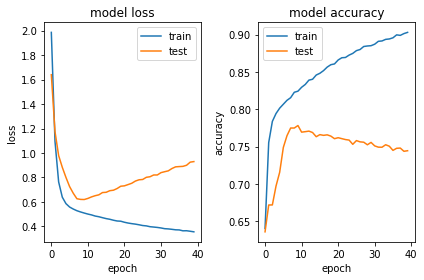

In [24]:
# create model
def model10(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(Dense(80, activation='relu')) 
    model.add(BatchNormalization())

    model.add(Dense(3, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model10(input_dim)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('L2_regul+BN+Layers',train_accuracy,test_accuracy))

## Try Dropout + l2_regularization + Batch Normalization + Deeper model

Train Loss: 0.480, Train Accuracy: 0.840
Test  Loss: 0.594, Test  Accuracy: 0.785


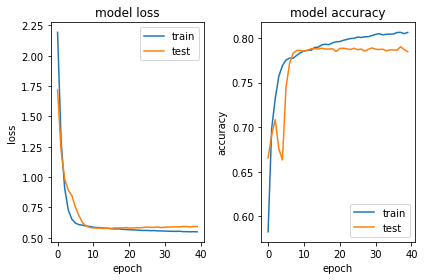

In [28]:
# create model
def model11(input_dim=100):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(80, activation='relu')) 
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(3, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

    return model

model = model11(input_dim)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=0)

plot_history(history)
train_accuracy, test_accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
results.append(('Dropout+L2_regul+BN+Layers',train_accuracy,test_accuracy))

## Plot various models

                      Model     Train      Test
                      Basic  0.857225  0.785702
                    Dropout  0.839222  0.795272
                Dropout+LRS  0.834737  0.793781
                 Dropout+BN  0.850210  0.788742
           Dropout+L2_regul  0.784547  0.779679
              Dropout+Noise  0.824898  0.794496
       Dropout+Noise+Layers  0.828067  0.794586
    Dropout+L2_regul+Layers  0.833242  0.789130
          Dropout+BN+Layers  0.854133  0.792231
         L2_regul+BN+Layers  0.927705  0.744440
 Dropout+L2_regul+BN+Layers  0.839937  0.784628


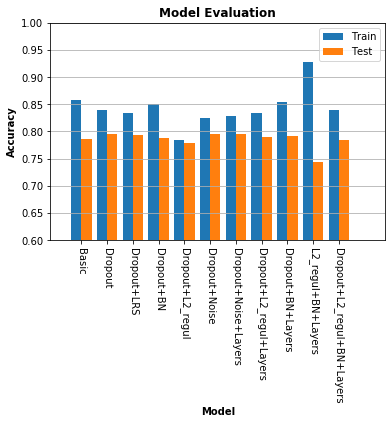

In [32]:
results_df = pd.DataFrame(results, columns=['Model','Train','Test'])
models = results_df['Model']
train = results_df['Train']
test = results_df['Test']
print (results_df.to_string(index=False))
results_df.to_csv("results.csv", index=False)

fig = plt.figure()
ax = plt.subplot(111)
ind = np.arange(len(models))  # the x locations for the groups
width = 0.4       # the width of the bars

rects1 = ax.bar(ind,      train, width, label='Train')
rects2 = ax.bar(ind+width, test, width, label='Test')

ax.set_title("Model Evaluation", fontweight='bold')
ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.legend(loc='best')
ax.yaxis.grid()

ax.set_ylim((0.6,1))
ax.set_xlim((-1,len(models)+1))
ax.set_xticks(ind+width*0.5)
ax.set_xticklabels(models, rotation=-90 );

## Loss and Accuracy

In [27]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print (f"Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print (f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

Train Loss: 0.306, Train Accuracy: 0.928
Test Loss: 0.930, Test Accuracy: 0.744


## Clasification Report

In [33]:
pred = model.predict(X_test)
y_obs = y_encoder.inverse_transform(y_test)
y_pred = y_encoder.inverse_transform(pred)
print(classification_report(y_obs,y_pred))

              precision    recall  f1-score   support

           C       0.77      0.70      0.73      6931
           E       0.79      0.79      0.79     13028
           H       0.79      0.83      0.81     13583

    accuracy                           0.78     33542
   macro avg       0.78      0.77      0.78     33542
weighted avg       0.78      0.78      0.78     33542



## Spot Check

In [34]:
input_sequence = df['sequence'].head(20).to_list()
ss = df['ss'].head(20).to_list()
for seq, label in zip(input_sequence,ss):
    encoded_sequence = encode_sequence(seq, encoder)
    pred  = model.predict(encoded_sequence)
    pred_label = y_encoder.inverse_transform(pred)[0][0]
    correct = '' if label == pred_label else 'X'
    print (f"sequence: {seq},  Secondary Structure: {label}, Predicted: {pred_label}, {correct}")


sequence: TNSLRMLQ,  Secondary Structure: H, Predicted: H, 
sequence: IFEMLRID,  Secondary Structure: H, Predicted: H, 
sequence: WDEAAVNL,  Secondary Structure: H, Predicted: H, 
sequence: PKLKAFLA,  Secondary Structure: H, Predicted: H, 
sequence: ERIYMICF,  Secondary Structure: E, Predicted: E, 
sequence: YTTRQIGA,  Secondary Structure: E, Predicted: E, 
sequence: IFNMVVEI,  Secondary Structure: E, Predicted: E, 
sequence: WDEASVNL,  Secondary Structure: H, Predicted: H, 
sequence: WKRQTLGQ,  Secondary Structure: H, Predicted: E, X
sequence: QSRLTMLL,  Secondary Structure: H, Predicted: H, 
sequence: NGDILVWN,  Secondary Structure: E, Predicted: E, 
sequence: YCNLMMCC,  Secondary Structure: H, Predicted: E, X
sequence: MRITDCRE,  Secondary Structure: E, Predicted: E, 
sequence: YKTTQVEK,  Secondary Structure: E, Predicted: E, 
sequence: VPVHFDAS,  Secondary Structure: E, Predicted: E, 
sequence: TEYKLVVV,  Secondary Structure: E, Predicted: E, 
sequence: SYTCEATH,  Secondary Structu